# Yelp Review Sentiment Classification

In this project, I will build a classifier that can predict how a user feels (positively or negatively) about a given restaurant from their review. This is an example of **sentiment analysis**: being able to quantify an individual's opinion about a particular topic merely from the words they use.




![Example of a Yelp review](https://drive.google.com/uc?export=view&id=1uIjM2_IR0xEXnSuO34fC44hDvXMJYMLg)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
import wordcloud
import os
import sys
pd.options.mode.chained_assignment = None #suppress warnings

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!python -m spacy download en_core_web_md
import en_core_web_md
text_to_nlp = spacy.load('en_core_web_md')



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hmzabanna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hmzabanna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hmzabanna\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     - -------------------------------------- 1.0/33.5 MB 10.1 MB/s eta 0:00:04
     ----- ---------------------------------- 4.5/33.5 MB 15.8 MB/s eta 0:00:02
     ---------- ----------------------------- 8.4/33.5 MB 16.8 MB/s eta 0:00:02
     -------------- ------------------------ 12.1/33.5 MB 17.1 MB/s eta 0:00:02
     ----------------- --------------------- 15.2/33.5 MB 16.8 MB/s eta 0:00:02
     --------------------- ----------------- 18.6/33.5 MB 16.8 MB/s eta 0:00:01
     ------------------------- ------------- 21.5/33.5 MB 17.2 MB/s eta 0:00:01
     ---------------------------- ---------- 24.6/33.5 MB 16.3 MB/s eta 0:00:01
     -------------------------------- ------ 28.0/33.5 MB 16.3 MB/s eta 0:00:01
     --------------------------------------  32.8/33.5 MB 17.1 MB/s eta 0:00:01
     --------------------------------------- 33.5/33.5 MB 16.7 MB/s eta 0:00:00
✔ Download and installation successful
You can n

In [16]:
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket/yelp_final.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv"


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


# Data Exploration

First I will read the file containing the reviews and take a look at the data available.

In [17]:
# read the data in using 'pd.read_csv('file')'
yelp_full = pd.read_csv('yelp_final.csv')
yelp_full.head()

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4


Let's keep only the two columns we need:



In [18]:
needed_columns = ['stars', 'text']
yelp = yelp_full[needed_columns]
yelp.head()

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
3,5,General Manager Scott Petello is a good egg!!!...
4,5,Drop what you're doing and drive here. After I...


The text column is the one we are primarily focused with. Let's take a look at a few of these reviews to better understand everything.

In [19]:
num_stars = 2

for t in yelp[yelp['stars'] == num_stars]['text'].head(20).values:
    print (t)

Was it worth the 21$ for a salad and small pizza? Absolutely not! Bad service. Maybe the guys grandma died I don't know. I want to tell you what really made me mad about the experience. We order the small pizza and salad and the guys could have cared less and took our $ and we sat down. We were looking around and hmm, there's a sign saying "x large pizza and large salad only 23$". Wow that would have been nice if the guy told us that. I left hungry, mad and unsatisfied. 

To the owner: teach your employees the value of upselling and telling the specials. Something so small can affect a customers experience negatively. 

And your salads are severely overpriced 

Won't go back unless I'm desperate.
This is my first time back in years. It will be my last. I was in the bar area for lunch it was almost 1hour 25 min before I could get out. Ten min before my drink order and almost as long before food order. A secound drink forget it. Guy next to me walked out.
I feel the Days Inn Tempe is bes

#### Word Clouds

Another way to take a look at the most prominent words in any given star rating is through the use of word clouds.

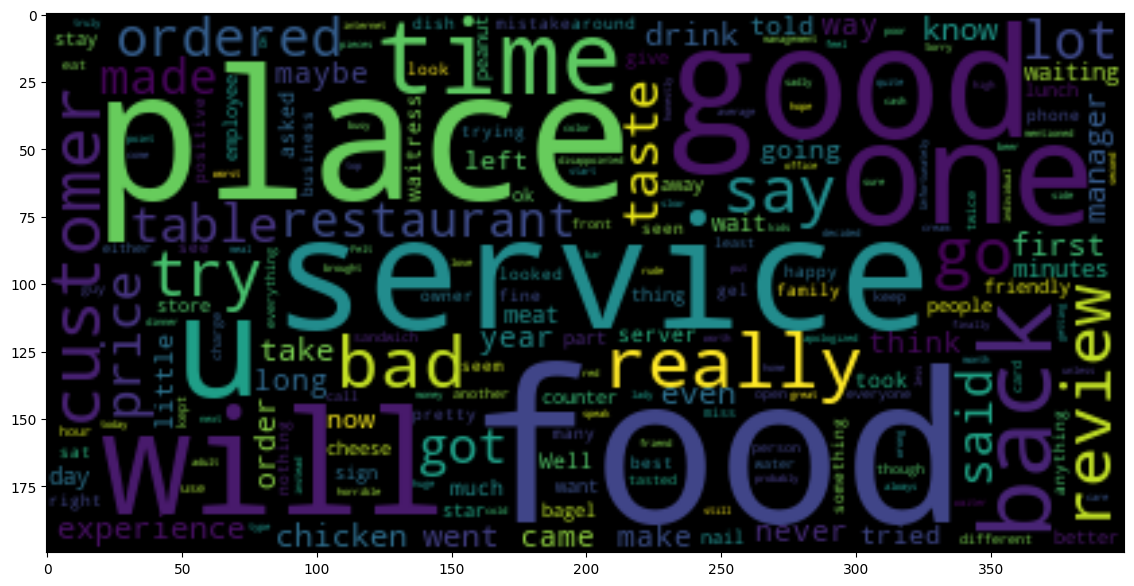

In [20]:
num_stars =  1
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '

wordcloud = WordCloud()
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

# Preparing the Data for Machine Learning

We'll need to prepare our data to use logistic regression. First, let's prepare our output column:

I'm going to try to predict the sentiment - **positive** or **negative** - based on a review's text.

In order to reduce our problem to a **binary classification** (two classes) problem, we will:

 - label 4 and 5 star reviews as 'good'
 - label 1, 2, 3 star reviews as 'bad'

In [21]:
def is_good_review(num_stars):
    if num_stars >= 4:
        return True
    else:
        return False

yelp['is_good_review'] = yelp['stars'].apply(is_good_review)
yelp.head()

,stars,text,is_good_review
0,5,My wife took me here on my birthday for breakf...,True
1,5,I have no idea why some people give bad review...,True
2,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",True
3,5,General Manager Scott Petello is a good egg!!!...,True
4,5,Drop what you're doing and drive here. After I...,True


## Text Preprocessing

I'll need a few steps to preprocess our text and represent it numerically.

## Tokenization

First of all, I would like to **tokenize** each review: convert it from a single string into a list of words.

In [22]:
example_text = "All the people I spoke to were super nice and very welcoming."
tokens = word_tokenize(example_text)
tokens

['All',
 'the',
 'people',
 'I',
 'spoke',
 'to',
 'were',
 'super',
 'nice',
 'and',
 'very',
 'welcoming',
 '.']

## Stopwords

Next, let's remove **stopwords**: words which are there to provide grammatical structure, but don't give us much information about a review's sentiment.

In [24]:
example_word = "the"
if example_word.lower() in STOP_WORDS:
  print ('"' + example_word + '" is a stop word.')
else:
  print ('"' + example_word + '" is NOT a stop word.')

"the" is a stop word.


I'm going to remove these stopwords from the user reviews.

## Vectors

Finally, we'll need to convert our text to **vectors**, or lists of numbers. I'll start off doing this with Bag of Words, but I'll talk about another approach later!


### Bag of Words

In a **bag of words** approach, we count how many times each word was used in each review.

Suppose we want to represent two **reviews**:
- "The food was great. The ambience was also great."
- "Great ambience, but not great food!"

First we define our vocabulary. This is *each unique word* in the review. So our **vocabulary** is:
- [also, ambience, but, food, great, not, the, was].

Next, we count up how many times each word was used! (You can also think of this as adding up one-hot encodings.)

Our reviews are encoded as:
- **First review:** [1, 1, 0, 1, 2, 0, 2, 2]. Can you explain why?
- **Second review:** [0, 1, 1, 1, 2, 1, 0, 0] Fill it in here!



## Preprocessing Our Text in Action

First, let's select our input *X* and output *y*:

In [26]:
X_text = yelp['text']
y = yelp['is_good_review']

Now, let's prepare the data! First, I'll use CountVectorizer, a useful tool from Scikit-learn, to:
*   Tokenize the reviews
*   Remove stopwords
*   Prepare the vocabulary


In [25]:
def tokenize(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these
            clean_tokens.append(token.lemma_)
    return clean_tokens


In [27]:
bow_transformer = CountVectorizer(analyzer=tokenize, max_features=800).fit(X_text)

Now, we can see our entire vocabulary!

In [28]:
bow_transformer.vocabulary_

{'wife': np.int64(778),
 'take': np.int64(703),
 'birthday': np.int64(106),
 'breakfast': np.int64(121),
 'excellent': np.int64(266),
 ' ': np.int64(2),
 'perfect': np.int64(521),
 'sit': np.int64(641),
 'outside': np.int64(502),
 'waitress': np.int64(760),
 'food': np.int64(302),
 'arrive': np.int64(72),
 'quickly': np.int64(571),
 'busy': np.int64(133),
 'Saturday': np.int64(45),
 'morning': np.int64(464),
 'look': np.int64(421),
 'like': np.int64(409),
 'place': np.int64(534),
 'fill': np.int64(291),
 'pretty': np.int64(555),
 'early': np.int64(249),
 'well': np.int64(774),
 '\n\n': np.int64(1),
 'simply': np.int64(640),
 'good': np.int64(327),
 'sure': np.int64(696),
 'use': np.int64(745),
 'ingredient': np.int64(380),
 'fresh': np.int64(307),
 'order': np.int64(499),
 'amazing': np.int64(65),
 'menu': np.int64(450),
 'white': np.int64(776),
 'egg': np.int64(253),
 'vegetable': np.int64(752),
 'tasty': np.int64(707),
 'delicious': np.int64(223),
 'come': np.int64(177),
 '2': np.int

The number represents the **index** (alphabetical position) of a word in the vocabulary.

Now that our vocabulary is ready, I can **transform** each review into a bag of words.



In [29]:
X = bow_transformer.transform(X_text)

In [30]:
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0,3,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
819,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
820,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creating a Baseline Classifier

Now, back to the sentiment analysis problem! The data is ready for machine learning.

The problem is a classic two-class classification problem, and so we will use the tried-and-tested **Logistic Regression** machine learning model.

As always, I'll start by setting aside testing and training data and training the model.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Time to test the model

In [47]:
y_pred = logistic_model.predict(X_test)
accuracy = logistic_model.score(X_test, y_test)
print (accuracy)

0.7666666666666667


Time to try Out Reviews


In [54]:
example_review = "the food is good"
prediction = logistic_model.predict(bow_transformer.transform([example_review]))

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



This was a GOOD review!
